<a href="https://colab.research.google.com/github/utmgdsc/TAIL-Trackr/blob/bentoML/dogbreed_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"devshah2021","key":"7ca39cb5f414dd2979e6b8aa38f5f8dd"}'}

kaggle datasets download -d gpiosenka/70-dog-breedsimage-data-set

In [3]:
!mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d gpiosenka/70-dog-breedsimage-data-set

 98% 211M/215M [00:07<00:00, 24.8MB/s]
100% 215M/215M [00:07<00:00, 28.6MB/s]


In [ ]:
!unzip /content/70-dog-breedsimage-data-set.zip

In [8]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import PIL
import cv2
import requests
from io import BytesIO
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.backend import clear_session

from tensorflow.keras.applications import InceptionResNetV2,InceptionV3
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.xception import Xception

In [9]:
TRAIN_DIR = '/content/test'
VAL_DIR = '/content/valid'
TEST_DIR = '/content/train'

DIMS = (224,224)
IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 42

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

train_directory = '/content/train'

# Get a list of all subdirectories (dog breed folders) within the train directory
dog_breed_folders = [folder for folder in os.listdir(train_directory) if os.path.isdir(os.path.join(train_directory, folder))]

# Number of images to visualize from each dog breed folder
images_per_breed = 3

# Iterate through each dog breed folder and visualize random images
for breed_folder in dog_breed_folders:
    breed_path = os.path.join(train_directory, breed_folder)
    image_files = [os.path.join(breed_path, file) for file in os.listdir(breed_path) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Randomly select 10 images (if available)
    if len(image_files) >= images_per_breed:
        random_images = random.sample(image_files, images_per_breed)
    else:
        random_images = image_files

    # Visualize the randomly selected images
    plt.figure(figsize=(15, 5))
    plt.suptitle(breed_folder)

    for i, image_path in enumerate(random_images):
        plt.subplot(2, 5, i + 1)
        img = mpimg.imread(image_path)
        plt.imshow(img)
        plt.axis('off')

    plt.show()







In [10]:
data_gen = ImageDataGenerator(rescale=1/255)

In [11]:
train_data = data_gen.flow_from_directory(batch_size=BATCH_SIZE, directory=TRAIN_DIR, shuffle=True,
                                            target_size=DIMS, class_mode='categorical')

val_data = data_gen.flow_from_directory(batch_size=BATCH_SIZE, directory=VAL_DIR, shuffle=True,
                                            target_size=DIMS, class_mode='categorical')

test_data = data_gen.flow_from_directory(batch_size=BATCH_SIZE, directory=TEST_DIR, shuffle=True,
                                            target_size=DIMS, class_mode='categorical')

Found 700 images belonging to 70 classes.
Found 700 images belonging to 70 classes.
Found 7946 images belonging to 70 classes.


In [12]:
label_mapper = np.asarray(list(train_data.class_indices.keys()))
label_mapper

array(['Afghan', 'African Wild Dog', 'Airedale', 'American Hairless',
       'American Spaniel', 'Basenji', 'Basset', 'Beagle',
       'Bearded Collie', 'Bermaise', 'Bichon Frise', 'Blenheim',
       'Bloodhound', 'Bluetick', 'Border Collie', 'Borzoi',
       'Boston Terrier', 'Boxer', 'Bull Mastiff', 'Bull Terrier',
       'Bulldog', 'Cairn', 'Chihuahua', 'Chinese Crested', 'Chow',
       'Clumber', 'Cockapoo', 'Cocker', 'Collie', 'Corgi', 'Coyote',
       'Dalmation', 'Dhole', 'Dingo', 'Doberman', 'Elk Hound',
       'French Bulldog', 'German Sheperd', 'Golden Retriever',
       'Great Dane', 'Great Perenees', 'Greyhound', 'Groenendael',
       'Irish Spaniel', 'Irish Wolfhound', 'Japanese Spaniel', 'Komondor',
       'Labradoodle', 'Labrador', 'Lhasa', 'Malinois', 'Maltese',
       'Mex Hairless', 'Newfoundland', 'Pekinese', 'Pit Bull',
       'Pomeranian', 'Poodle', 'Pug', 'Rhodesian', 'Rottweiler',
       'Saint Bernard', 'Schnauzer', 'Scotch Terrier', 'Shar_Pei',
       'Shiba In

In [13]:
IMG_SHAPE = (224,224,3)
base_model = InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet', classes=70)

87910968/87910968 [==============================] - 3s 0us/step


In [14]:
base_model.trainable = False

model = Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())
model.add(Dense(70,activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 5, 5, 2048)        0         
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 70)                143430    
                                                                 
Total params: 21946214 (83.72 MB)
Trainable params: 143430 (560.27 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [15]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=2, factor=0.001)
es = EarlyStopping(monitor='val_loss', verbose=2, patience=5, min_delta=0.001)

In [22]:
results = model.fit(train_data, validation_data=val_data,
                steps_per_epoch = train_data.samples//BATCH_SIZE,
                validation_steps = val_data.samples//BATCH_SIZE,
                epochs=10, verbose=1, callbacks=[reduce_lr,es])

Epoch 1/10
21/21 [==============================] - 156s 8s/step - loss: 0.5399 - accuracy: 0.8997 - val_loss: 1.4661 - val_accuracy: 0.8512 - lr: 0.0100
Epoch 2/10
21/21 [==============================] - 156s 8s/step - loss: 0.1745 - accuracy: 0.9596 - val_loss: 1.5718 - val_accuracy: 0.8542 - lr: 0.0100
Epoch 3/10
21/21 [==============================] - 156s 8s/step - loss: 0.2178 - accuracy: 0.9641 - val_loss: 1.8060 - val_accuracy: 0.8571 - lr: 0.0100
Epoch 4/10
21/21 [==============================] - 146s 7s/step - loss: 0.1203 - accuracy: 0.9716 - val_loss: 1.3527 - val_accuracy: 0.8839 - lr: 0.0100
Epoch 5/10
21/21 [==============================] - 160s 8s/step - loss: 0.0743 - accuracy: 0.9880 - val_loss: 1.5328 - val_accuracy: 0.8661 - lr: 0.0100
Epoch 6/10
21/21 [==============================] - 157s 8s/step - loss: 0.0631 - accuracy: 0.9895 - val_loss: 1.3365 - val_accuracy: 0.9018 - lr: 0.0100
Epoch 7/10
21/21 [==============================] - 147s 7s/step - loss: 0.0

In [23]:
model.evaluate(val_data)

22/22 [==============================] - 79s 3s/step - loss: 1.4978 - accuracy: 0.9000


[1.4977608919143677, 0.8999999761581421]

In [24]:
def predictor(img):
    display(img)
    arr = img_to_array(img)
    arr = arr/255.0
    arr = np.expand_dims(arr,0)
    res = model.predict(arr)
    print(res.shape)
    idx = res.argmax()
    return label_mapper[idx], res[0][idx]


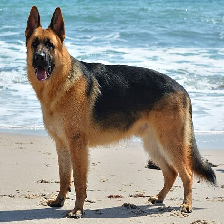

1/1 [==============================] - 1s 1s/step
(1, 70)


('German Sheperd', 1.0)

In [25]:
url = 'https://upload.wikimedia.org/wikipedia/commons/d/d0/German_Shepherd_-_DSC_0346_%2810096362833%29.jpg'
response = requests.get(url)
img = load_img(BytesIO(response.content), target_size=DIMS)

val,prob = predictor(img)
val,prob